# Natural Language Processing

## Word2Vec

Let's work on skipgram-based implementation of word2vec.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## 1. Define some very simple data for understanding

In [2]:
corpus = ["apple banana ice", "banana orange fruit", "orange ice fruit", "orange grapes fruit", "banana ice fruit", "grapes fruit ice", 
          "dog cat animal", "cat monkey animal", "monkey dog animal", "conda dog animal", "monkey dog conda", "monkey conda animal"]

In [3]:
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'ice'],
 ['banana', 'orange', 'fruit'],
 ['orange', 'ice', 'fruit'],
 ['orange', 'grapes', 'fruit'],
 ['banana', 'ice', 'fruit'],
 ['grapes', 'fruit', 'ice'],
 ['dog', 'cat', 'animal'],
 ['cat', 'monkey', 'animal'],
 ['monkey', 'dog', 'animal'],
 ['conda', 'dog', 'animal'],
 ['monkey', 'dog', 'conda'],
 ['monkey', 'conda', 'animal']]

In [4]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab

['conda',
 'orange',
 'fruit',
 'ice',
 'monkey',
 'apple',
 'cat',
 'dog',
 'grapes',
 'animal',
 'banana']

In [5]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{'conda': 0, 'orange': 1, 'fruit': 2, 'ice': 3, 'monkey': 4, 'apple': 5, 'cat': 6, 'dog': 7, 'grapes': 8, 'animal': 9, 'banana': 10}


In [6]:
#vocab size
voc_size = len(vocab)
print(voc_size)

11


## 2. Prepare train data

In [7]:
def random_batch(batch_size, word_sequence):
    
    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]
            context = [word2index[sent[i - 1]], word2index[sent[i + 1]]]
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    # here we NOT gonna make input; we shall learn the embedding ourself
    # we cannot train using taking integer as input...
    for i in random_index:
        random_inputs.append(np.eye(voc_size)[skip_grams[i][0]])  # target,e g., [0, 0, 0, 0, 0, 1, 0, 0]
        random_labels.append(skip_grams[i][1])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

### Testing the method

In [8]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ", input_batch)
print("Target: ", target_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Target:  [9 4]


## 3. Model

In [9]:
class Word2Vec(nn.Module):
    def __init__(self, embedding_size):
        super(Word2Vec, self).__init__()
        # W and WT is not Traspose relationship
        self.W = nn.Linear(voc_size, embedding_size, bias=False) # voc_size > embedding_size weight
        self.WT = nn.Linear(embedding_size, voc_size, bias=False) # embedding_size > voc_size weight

    def forward(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = self.W(X) # hidden_layer : [batch_size, embedding_size]
        output_layer = self.WT(hidden_layer) # output_layer : [batch_size, voc_size]
        return output_layer

## 4. Training

In [10]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model          = Word2Vec(embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Training
num_epochs = 5000
for epoch in range(num_epochs):
    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch = torch.Tensor(input_batch) #[batch_size, voc_size]
    target_batch = torch.LongTensor(target_batch) #[batch_size]

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 2.200160
Epoch: 2000 cost = 1.612707
Epoch: 3000 cost = 1.431959
Epoch: 4000 cost = 1.482032
Epoch: 5000 cost = 1.329087


## 5. Plotting the embeddings

In [12]:
W, WT = model.parameters()
W.shape #embedding (x, y), vocab (unique vocabs)

torch.Size([2, 11])

In [13]:
#x embedding of the first vocab
W[0][1].item()

-1.3035638332366943

In [14]:
#y embedding of the first vocab
W[1][1].item()

-1.2108172178268433

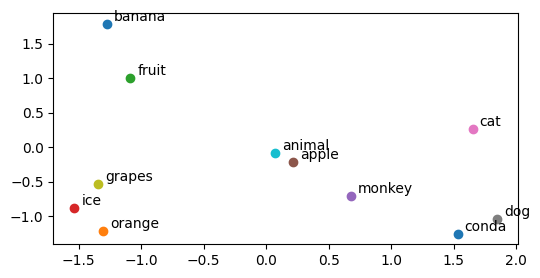

In [15]:
plt.figure(figsize=(6,3))
for i, label in enumerate(vocab): #loop each unique vocab
    W, WT = model.parameters()
    x, y = W[0][i].item(), W[1][i].item()
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [16]:
vocab

['conda',
 'orange',
 'fruit',
 'ice',
 'monkey',
 'apple',
 'cat',
 'dog',
 'grapes',
 'animal',
 'banana']

In [17]:
#let's try similarity between first and second, and second and third

#embedding = x, y, vocab = 0
first      = [W[0][0].item(), W[1][0].item()]
second     = [W[0][1].item(), W[1][1].item()]
third      = [W[0][2].item(), W[1][2].item()]

In [18]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"{vocab[0]} vs. {vocab[1]}: ",   cos_sim(first, second))
print(f"{vocab[0]} vs. {vocab[2]}:",    cos_sim(second, third))
print(f"{vocab[0]} vs. {vocab[0]}: ",   cos_sim(first, first))

conda vs. orange:  -0.13575076929921068
conda vs. fruit: 0.07660935544700968
conda vs. conda:  1.0


In [19]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"{vocab[0]} vs. {vocab[1]}: ",   cos_sim(first, second))
print(f"{vocab[0]} vs. {vocab[2]}:",    cos_sim(second, third))
print(f"{vocab[0]} vs. {vocab[0]}: ",   cos_sim(first, first))

conda vs. orange:  -0.1357507692992106
conda vs. fruit: 0.07660935544700964
conda vs. conda:  1
